Polynomial task RMSE : 2.9224e+02


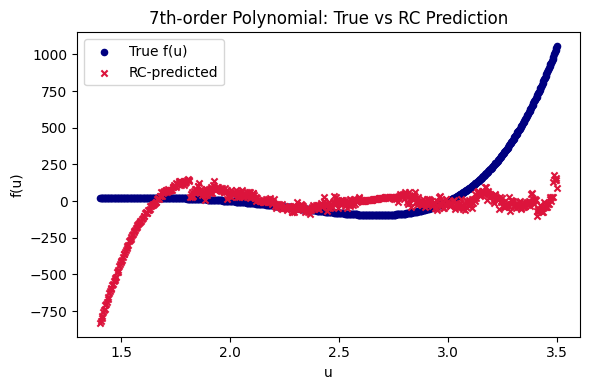

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# -----------------------------------
# the target polynomial f(x)
#    f(x) = (x-3)(x-2)(x-1)x(x+1)(x+2)(x+3)
# -----------------------------------
def poly7(x):
    return (x-3)*(x-2)*(x-1)*x*(x+1)*(x+2)*(x+3)

# sample L points uniformly in [-3.5, 3.5]
L = 2000
u = np.linspace(-3.5, 3.5, L).reshape(-1,1)
v = poly7(u).ravel()  # shape (L,)

# split into train/test
frac_train = 0.7
n_train = int(frac_train * L)
u_train, u_test = u[:n_train], u[n_train:]
v_train, v_test = v[:n_train], v[n_train:]


def build_logistic_reservoir(u, P=500, amin=3.6, amax=4.0, init=0.5):
    """
    Maps each scalar input u[j] to parameter a_j in [amin,amax],
    iterates logistic map x_{k+1} = a_j * x_k * (1 - x_k) for P steps,
    starting from x_0 = init. Returns reservoir matrix R of shape
    (len(u), P).
    """
    N = len(u)
    R = np.zeros((N, P))
    umin, umax = u.min(), u.max()
    for j in range(N):
        # linear map input -> logistic parameter
        a_j = amin + (amax - amin) * (u[j,0] - umin) / (umax - umin)
        x = init
        for k in range(P):
            x = a_j * x * (1 - x)
            R[j, k] = x
    return R

# build reservoir for train and test
P = 100
R_train = build_logistic_reservoir(u_train, P=P)
R_test  = build_logistic_reservoir(u_test,  P=P)


ridge = Ridge(alpha=1e-8)
ridge.fit(R_train, v_train)

# predict on test set
v_pred = ridge.predict(R_test)

# compute benchmark: RMSE
rmse = np.sqrt(mean_squared_error(v_test, v_pred))
print(f"Polynomial task RMSE : {rmse:.4e}")

plt.figure(figsize=(6,4))
plt.scatter(u_test, v_test,  color='navy', s=20, label='True f(u)')
plt.scatter(u_test, v_pred, color='crimson', s=20, marker='x',
            label='RC-predicted')
plt.xlabel('u')
plt.ylabel('f(u)')
plt.title('7th-order Polynomial: True vs RC Prediction')
plt.legend()
plt.tight_layout()
plt.show()


Test RMSE (x,y,z): [1.60375578 4.59942948 6.16332905]


ModuleNotFoundError: No module named 'mpl_toolkits.mplot3d'

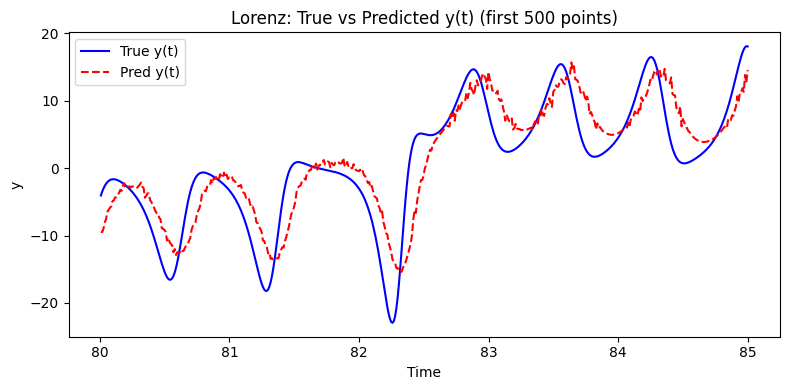

<Figure size 800x800 with 0 Axes>

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d import Axes3D

def lorenz_system(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

# integrate Lorenz over t ∈ [0,100]
T = 100.0
N = 10000
t = np.linspace(0, T, N)
x0 = [1.0, 1.0, 1.0]
data = odeint(lorenz_system, x0, t)

# inputs u[n] = x[n], targets y[n] = [x[n+1], y[n+1], z[n+1]]
U = data[:-1, 0].reshape(-1, 1)   # shape (N-1,1)
Y = data[1:, :]                  # shape (N-1,3)

# split into train / test
train_frac = 0.8
split = int(len(U) * train_frac)
U_train, U_test = U[:split], U[split:]
Y_train, Y_test = Y[:split], Y[split:]


def build_logistic_reservoir(u, P=50, amin=3.6, amax=4.0, init=0.5):
    """
    For each scalar input u[j], map to a parameter a_j in [amin,amax].
    Then iterate logistic map x_{k+1} = a_j * x_k * (1 - x_k) for P steps,
    starting from x_0 = init.  Collect the P values as the reservoir state.
    """
    N = len(u)
    R = np.zeros((N, P))
    # find input range for scaling
    umin, umax = u.min(), u.max()
    for j in range(N):
        # scale input to logistic parameter a_j
        a_j = amin + (amax - amin) * (u[j,0] - umin) / (umax - umin)
        x = init
        for k in range(P):
            x = a_j * x * (1 - x)
            R[j, k] = x
    return R

# build reservoirs
P = 100
R_train = build_logistic_reservoir(U_train, P=P)
R_test  = build_logistic_reservoir(U_test,  P=P)


ridge = Ridge(alpha=1e-6)
ridge.fit(R_train, Y_train)

# predict on test set
Y_pred = ridge.predict(R_test)

# compute benchmark: RMSE per component
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred, multioutput='raw_values'))
print(f"Test RMSE (x,y,z): {rmse}")


# 4.1 Time-series: compare y-component
t_test = t[1+split:1+split+500]  # first 500 test points
plt.figure(figsize=(8,4))
plt.plot(t_test, Y_test[:500,1], 'b', label='True y(t)')
plt.plot(t_test, Y_pred[:500,1], 'r--', label='Pred y(t)')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Lorenz: True vs Predicted y(t) (first 500 points)')
plt.legend()
plt.tight_layout()

# 4.2 3D attractor: true vs predicted
fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
from mpl_toolkits.mplot3d import axes3d
ax = axes3d.Axes3D(fig)

# plot a segment to avoid overcrowding
idx0 = 200
idx1 = 1200
ax.plot(data[split+1+idx0:split+1+idx1,0],
        data[split+1+idx0:split+1+idx1,1],
        data[split+1+idx0:split+1+idx1,2],
        c='navy', lw=0.5, label='True')
ax.plot(Y_pred[idx0:idx1,0],
        Y_pred[idx0:idx1,1],
        Y_pred[idx0:idx1,2],
        c='crimson', lw=0.5, linestyle='--', label='Predicted')
ax.set_title('Lorenz Attractor: True vs Predicted')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.legend()
plt.tight_layout()

plt.show()

Test RMSE (x,y,z): [3.76673884 2.93538559 8.36222649]


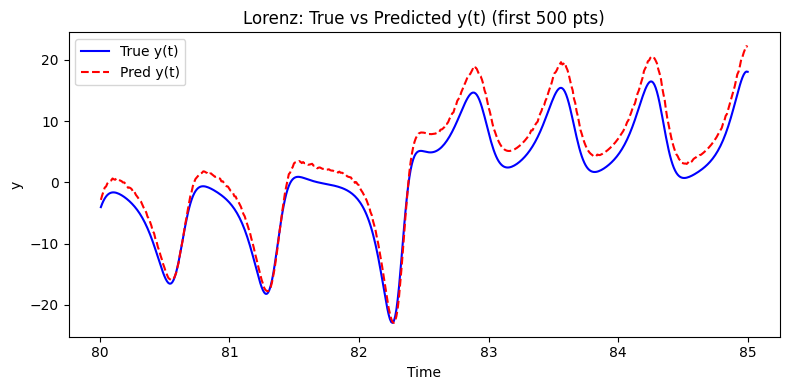

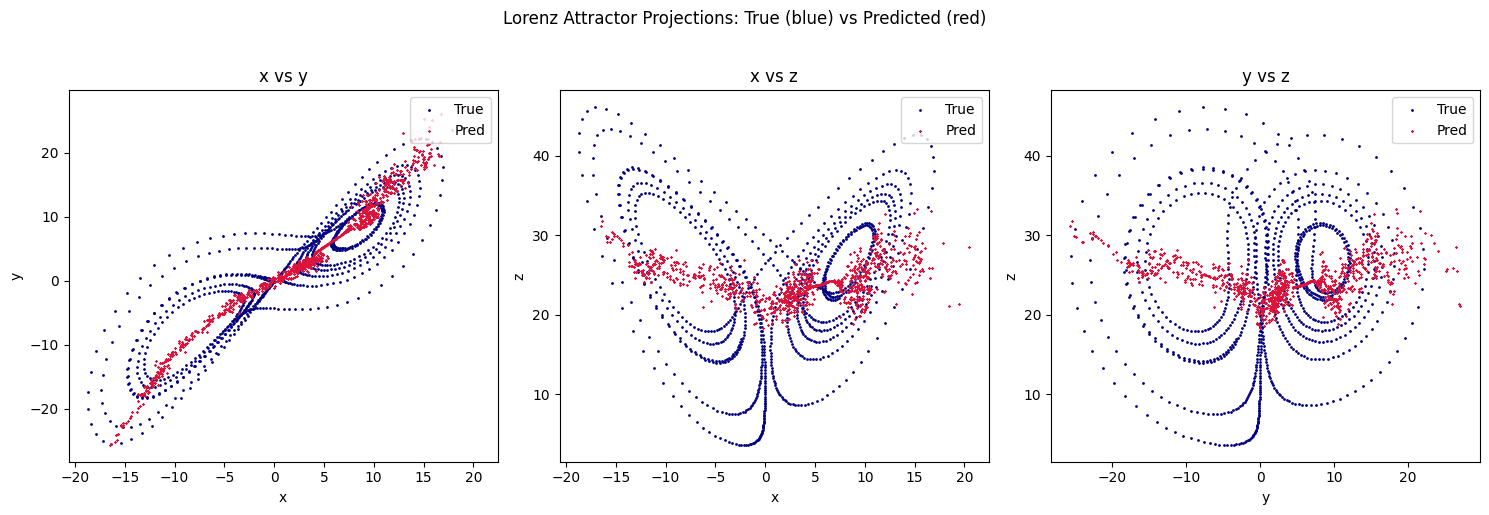

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


def lorenz_system(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

T = 100.0
N = 10000
t = np.linspace(0, T, N)
x0 = [1.0, 1.0, 1.0]
data = odeint(lorenz_system, x0, t)

# inputs u[n] = x[n], targets y[n] = [x[n+1], y[n+1], z[n+1]]
U = data[:-1, 1].reshape(-1, 1)   # shape (N-1,1)
Y = data[1:, :]                  # shape (N-1,3)

# split into train / test
train_frac = 0.8
split = int(len(U) * train_frac)
U_train, U_test = U[:split], U[split:]
Y_train, Y_test = Y[:split], Y[split:]

def build_logistic_reservoir(u, P=200, amin=3.6, amax=4.0, init=0.5):
    N = len(u)
    R = np.zeros((N, P))
    umin, umax = u.min(), u.max()
    for j in range(N):
        a_j = amin + (amax - amin) * (u[j,0] - umin) / (umax - umin)
        x = init
        for k in range(P):
            x = a_j * x * (1 - x)
            R[j, k] = x
    return R

R_train = build_logistic_reservoir(U_train)
R_test  = build_logistic_reservoir(U_test)


ridge = Ridge(alpha=1e-6)
ridge.fit(R_train, Y_train)

# predict on test set
Y_pred = ridge.predict(R_test)

# compute benchmark: RMSE per component
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred, multioutput='raw_values'))
print(f"Test RMSE (x,y,z): {rmse}")


# Time-series: compare y-component
t_test = t[1+split:1+split+500]  # first 500 test points
plt.figure(figsize=(8,4))
plt.plot(t_test, Y_test[:500,1], 'b',  label='True y(t)')
plt.plot(t_test, Y_pred[:500,1],'r--',label='Pred y(t)')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Lorenz: True vs Predicted y(t) (first 500 pts)')
plt.legend()
plt.tight_layout()

# 2D projections of the attractor: (x vs y), (x vs z), (y vs z)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
pairs = [ (0,1,'x','y'),
          (0,2,'x','z'),
          (1,2,'y','z')]
start, end = split+100, split+1100  # subset for clarity

for ax, (i,j,xi,yj) in zip(axes, pairs):
    ax.scatter(data[start:end,i],
               data[start:end,j],
               c='navy', s=1, label='True')
    ax.scatter(Y_pred[start-split:end-split,i],
               Y_pred[start-split:end-split,j],
               c='crimson', s=1, marker='x', label='Pred')
    ax.set_xlabel(xi); ax.set_ylabel(yj)
    ax.legend(loc='upper right')
    ax.set_title(f'{xi} vs {yj}')

fig.suptitle('Lorenz Attractor Projections: True (blue) vs Predicted (red)', y=1.02)
plt.tight_layout()
plt.show()


Closed‐loop RMSE (x,y,z): [11.80047404 12.67296085 10.25903679]


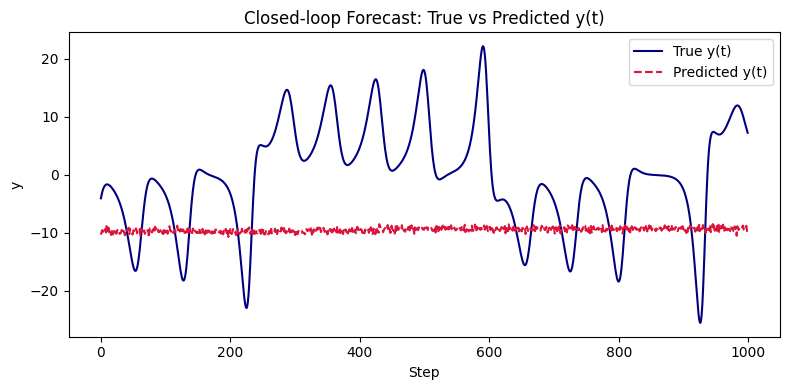

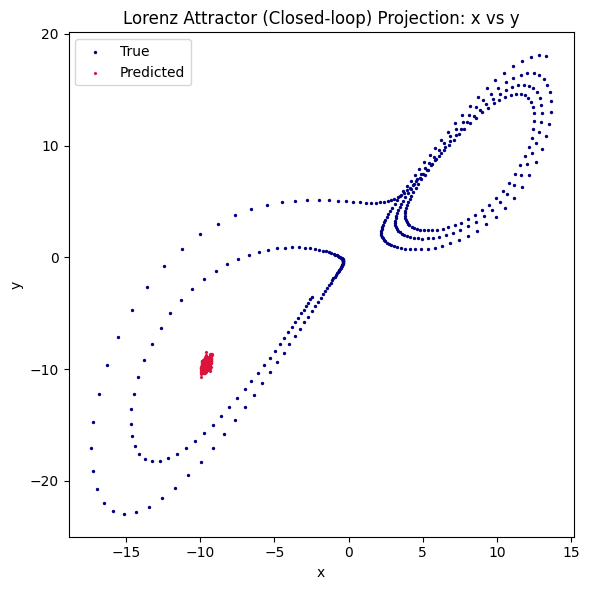

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


def lorenz_system(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# integration parameters
T = 100.0
N = 10000
t = np.linspace(0, T, N)
initial_state = [1.0, 1.0, 1.0]
data = odeint(lorenz_system, initial_state, t)

# prepare one‐step‐ahead dataset
U = data[:-1, 0].reshape(-1, 1)  # input: x[n]
Y = data[1:, :]                  # target: [x[n+1], y[n+1], z[n+1]]

# split into train / test
train_frac = 0.8
split = int(len(U) * train_frac)
U_train, U_test = U[:split], U[split:]
Y_train, Y_test = Y[:split], Y[split:]


def build_logistic_reservoir(u, P=100, amin=3.6, amax=4.0, init=0.5):
    """
    u: array of shape (n_samples,1)
    returns R of shape (n_samples, P)
    """
    n_samples = len(u)
    R = np.zeros((n_samples, P))
    umin, umax = u.min(), u.max()
    for j in range(n_samples):
        # scale u[j] into logistic parameter a_j
        a_j = amin + (amax - amin) * (u[j,0] - umin) / (umax - umin)
        xk = init
        for k in range(P):
            xk = a_j * xk * (1 - xk)
            R[j, k] = xk
    return R

# build reservoirs for train/test
P = 100
R_train = build_logistic_reservoir(U_train, P=P)
R_test  = build_logistic_reservoir(U_test,  P=P)

# aka Ridge regression
ridge = Ridge(alpha=1e-6)
ridge.fit(R_train, Y_train)

# predict on test set

horizon = 1000
preds = np.zeros((horizon, 3))

# initialize with the first test input
x_curr = U_test[0,0]
umin, umax = U.min(), U.max()

for i in range(horizon):
    # build reservoir state for current x_curr
    a_j = 3.6 + (4.0 - 3.6) * (x_curr - umin) / (umax - umin)
    r = np.zeros((1, P))
    xk = 0.5
    for k in range(P):
        xk = a_j * xk * (1 - xk)
        r[0, k] = xk

    # predict next [x,y,z]
    y_pred = ridge.predict(r)   # shape (1,3)
    preds[i] = y_pred

    # feedback: use predicted x as next input
    x_curr = y_pred[0, 0]

# true trajectory for comparison
true_future = data[split+1 : split+1+horizon]

# compute RMSE for each component
rmse_closed = np.sqrt(mean_squared_error(true_future, preds, multioutput='raw_values'))
print(f"Closed‐loop RMSE (x,y,z): {rmse_closed}")


# Time‐series: compare y‐component
plt.figure(figsize=(8, 4))
plt.plot(true_future[:,1],  label='True y(t)', color='navy')
plt.plot(preds[:,1], '--',  label='Predicted y(t)', color='crimson')
plt.xlabel('Step')
plt.ylabel('y')
plt.title('Closed‐loop Forecast: True vs Predicted y(t)')
plt.legend()
plt.tight_layout()

# 2D projection (x vs y) of a segment
start, end = 100, 500
plt.figure(figsize=(6, 6))
plt.scatter(true_future[start:end,0],
            true_future[start:end,1],
            s=2, label='True', color='navy')
plt.scatter(preds[start:end,0],
            preds[start:end,1],
            s=2, marker='x', label='Predicted', color='crimson')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lorenz Attractor (Closed‐loop) Projection: x vs y')
plt.legend()
plt.tight_layout()

plt.show()
